In [268]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, precision_recall_curve, recall_score, f1_score

# 1) Read dataset

In [269]:
'''
    training_set_values.csv: Independent features have both categorial and numberical values
    training_set_labels.csv: Target test results, for scoring models
    test_set_values.csv: This test data is not considered for modeling, as the training 
                         set is randomly split to have separate training and test data sets
'''
train = pd.read_csv('../data/training_set_values.csv', index_col='id')
target = pd.read_csv('../data/training_set_labels.csv', index_col='id')
test = pd.read_csv('../data/test_set_values.csv', index_col='id')

print("Training data: (Observations {}, features {})".format(train.shape[0], train.shape[1]))
print("Target data: (Observations {}, features {})".format(target.shape[0], target.shape[1]))
print("Test data: (Observations {}, features {})".format(test.shape[0], test.shape[1]))


Training data: (Observations 59400, features 39)
Target data: (Observations 59400, features 1)
Test data: (Observations 14850, features 39)


In [270]:
# How many numerical vs. how many categorical features
df_train_cat = train.select_dtypes(include='object')
df_train_num = train.select_dtypes(exclude='object')
print("\n2) Number of categorical features: :" , len(df_train_cat.columns), "\n", df_train_cat.columns)
print("\n\n2) Number of numerical featur`es: :" , len(df_train_num.columns), "\n", df_train_num.columns)


2) Number of categorical features: : 30 
 Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')


2) Number of numerical featur`es: : 9 
 Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'construction_year'],
      dtype='object')


In [271]:
df_train_cat.source_class.unique()

array(['groundwater', 'surface', 'unknown'], dtype=object)

In [272]:


def check_for_nans(df, what):
    if len(df.columns[df.isna().any()])==0:
        print("\nNumber of NaNs in {} = 0".format(what))
        lst = []
    else:
        print("\nFound NanNs in {}: \n".format(what), df.isna().sum())
        lst = df.columns[df.isna().any()]     
    return lst

train_cat_nans = check_for_nans(df_train_cat, "training categorical features")
train_num_nans = check_for_nans(df_train_num, "training numerical features")


Found NanNs in training categorical features: 
 date_recorded                0
funder                    3635
installer                 3655
wpt_name                     0
basin                        0
subvillage                 371
region                       0
lga                          0
ward                         0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
dtype: int64

Number 

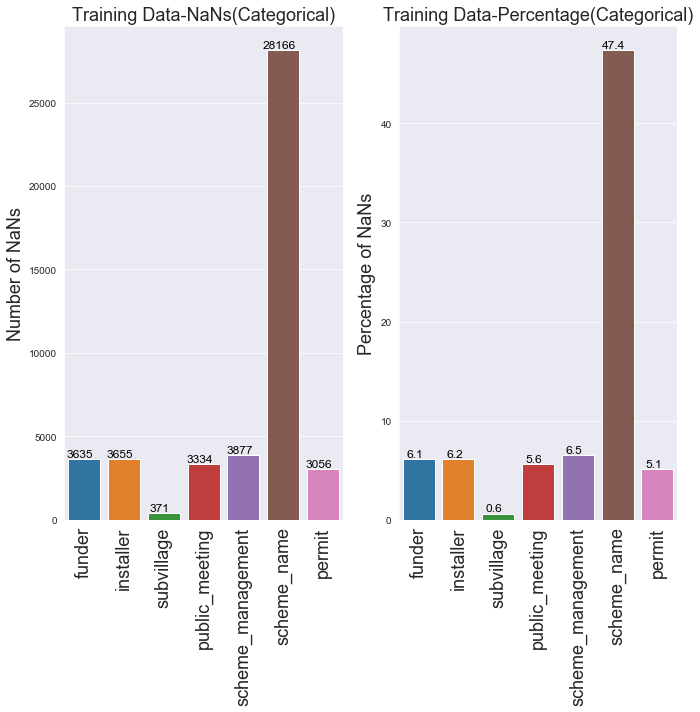

In [273]:
# Create a dictionary of columns with NaN values and the counts
df = pd.DataFrame(df_train_cat[train_cat_nans].isna().sum().to_dict(),index=['NaNs']).T

# Chart percentage of NaNs
df ['Percent'] = round(100*df/len(df_train_cat),2)

sns.set_style("darkgrid")
#fig, ax = plt.subplots(1,2, figsize=(5,5), sharey=True)

f = plt.figure(figsize=(10, 10))
gs = f.add_gridspec(1,2)

# Training data NaNs counts
with sns.axes_style("darkgrid"):
    ax1 = f.add_subplot(gs[0, 0])
    sb = sns.barplot(x=df.index, y=df.NaNs,data=df, ax=ax1)
    sb.set_title("Training Data-NaNs(Categorical)",fontsize=18 )
    sb.set_ylabel("Number of NaNs", fontsize=18)
    sb.set_xticklabels(sb.get_xticklabels(), rotation=90, fontsize=18);

    for p in sb.patches:
        sb.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', fontsize=12. )
    
# Training data NaNs Percent
with sns.axes_style("darkgrid"):
    ax2 = f.add_subplot(gs[0,1])
    sb = sns.barplot(x=df.index, y=df.Percent,data=df, ax=ax2)
    sb.set_title("Training Data-Percentage(Categorical)",fontsize=18 )
    sb.set_ylabel("Percentage of NaNs", fontsize=18)
    sb.set_xticklabels(sb.get_xticklabels(), rotation=90,fontsize=18);

    for p in sb.patches:
        sb.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black', fontsize=12. )
f.tight_layout()

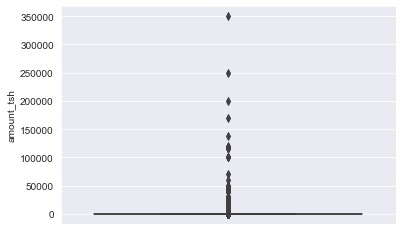

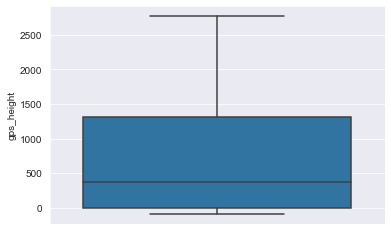

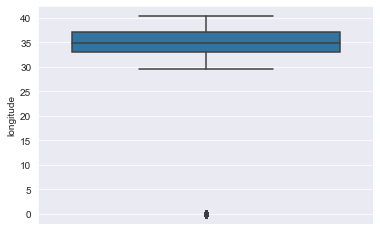

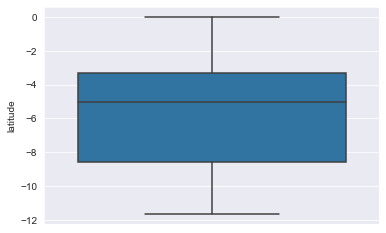

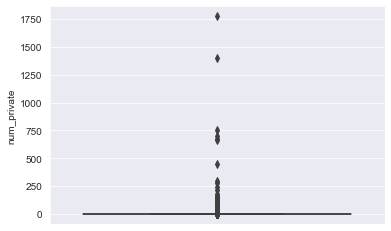

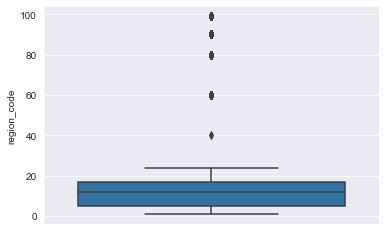

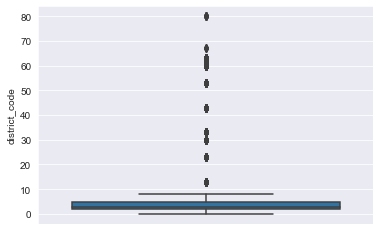

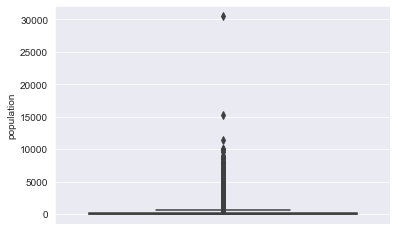

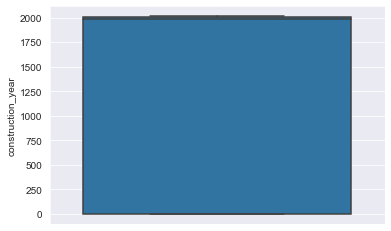

In [274]:
for col in range(len(df_train_num.columns)):
    df_train_num.columns[col]
    sns.boxplot(y=df_train_num[df_train_num.columns[col]])
    plt.show()

In [275]:
df_train_num

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
id,,,,,,,,,
69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999
8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010
34310,25.0,686,37.460664,-3.821329,0,21,4,250,2009
67743,0.0,263,38.486161,-11.155298,0,90,63,58,1986
19728,0.0,0,31.130847,-1.825359,0,18,1,0,0
...,...,...,...,...,...,...,...,...,...
60739,10.0,1210,37.169807,-3.253847,0,3,5,125,1999
27263,4700.0,1212,35.249991,-9.070629,0,11,4,56,1996
37057,0.0,0,34.017087,-8.750434,0,12,7,0,0


# Feature Selection and Engineering

In [276]:
df_train_num.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'construction_year'],
      dtype='object')

In [277]:
df_train_cat.columns

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [278]:
df_train_num.amount_tsh

id
69572    6000.0
8776        0.0
34310      25.0
67743       0.0
19728       0.0
          ...  
60739      10.0
27263    4700.0
37057       0.0
31282       0.0
26348       0.0
Name: amount_tsh, Length: 59400, dtype: float64

In [287]:
df_train_num.construction_year == 0

id
69572    False
8776     False
34310    False
67743    False
19728     True
         ...  
60739    False
27263    False
37057     True
31282     True
26348    False
Name: construction_year, Length: 59400, dtype: bool

In [288]:
                                                                    
df_train_num['age_of_pump'] = pd.DataFrame(df_train_cat['date_recorded']).applymap(lambda year: round(int(year.split(sep='-')[0]) + \
                                                            int(year.split(sep='-')[1])/12,2)) 


/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [289]:
#Prabhakar: Remove after Josh's pre-processing.... If construction year is 0, then replace it with mean
df_train_num=df_train_num.mask(df_train_num==0).fillna(df_train_num.mean())

df_train_num['age_of_pump'] = df_train_num['age_of_pump'] - df_train_num['construction_year']

In [290]:
df_train_num.age_of_pump

id
69572     12.250000
8776       3.250000
34310      4.170000
67743     27.080000
19728    710.927525
            ...    
60739     14.420000
27263     15.420000
37057    710.677525
31282    710.597525
26348      9.250000
Name: age_of_pump, Length: 59400, dtype: float64

# Build Modelsl

## Helper Functions

In [195]:
models = ['ALL', 'LGM', 'KNN', 'DTM', 'RFM']

KFold_split_param = 10    # KFold split parameter
random_state = 42        # for TTS
test_size = 0.2          # for TTS
cv_scoring = 'accuracy'  # for cross-validation scoring

def run_models(X , y, model):

    #Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=random_state)

    pscore = []
    # Instantiate the KFold object
    kf = KFold(n_splits=KFold_split_param)

    for train_ind, val_ind in kf.split(X_train,y_train):

        X_tt, y_tt = X_train.iloc[train_ind], y_train.iloc[train_ind]             
        X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
               
        ss = StandardScaler()
        X_tt = pd.DataFrame(ss.fit_transform(X_tt))
               
        #Standard Scaler strips of indices
        X_val = pd.DataFrame(ss.transform(X_val))        
        
        ''' 
             Run Logistic Regression Model
        '''
        if (model == 'ALL' or  model == 'LGM'):
            lg = LogisticRegression()
            lg.fit(X_tt, y_tt)                                                           
            y_pred = lg.predict(X_tt)
            print("Completed Logistical Regression Model")

        '''
             Run KNN Model
        '''
        if (model == 'ALL' or model == 'KNN'):
            print("Completed KNN Model")

        '''
             Run Decision Tree Model
        '''
        if (model == 'ALL' or model == 'DTM'):
            print("Completed Decision Tree Model")

        '''
             Run Random Tree Model
        '''        
        if (model == 'ALL' or model == 'RFM'):
            print("Completed Logistical Random Forest Model")

        '''
             Run LinearXGBoost Model
        '''
        if (model == 'ALL' or model == 'XGB'):
            print("Completed XGBoot Model")        
                
        
        pscore.append(precision_score(y_tt, y_pred, average=None))

    return pscore



        

TypeError: Indexing a Series with DataFrame is not supported, use the appropriate DataFrame column

In [196]:

df = df_train_num[['age_of_pump']]
ps = run_models(df, target, 'LGM' )

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Completed Logistical Regression Model


/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Completed Logistical Regression Model


/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Completed Logistical Regression Model


/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Completed Logistical Regression Model


/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Completed Logistical Regression Model


/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Completed Logistical Regression Model


/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Completed Logistical Regression Model


/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Completed Logistical Regression Model


/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Completed Logistical Regression Model


/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Completed Logistical Regression Model


/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [191]:
df_train_num.age_of_pump


id
69572      12.25
8776        3.25
34310       4.17
67743      27.08
19728    2011.58
          ...   
60739      14.42
27263      15.42
37057    2011.33
31282    2011.25
26348       9.25
Name: age_of_pump, Length: 59400, dtype: float64